In [10]:
from astropy.io import fits
import glob
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from photutils.centroids import centroid_com
from photutils import CircularAperture, CircularAnnulus,aperture_photometry
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils.utils import calc_total_error
from astropy.stats import sigma_clip
from astropy.table import Table
import pandas as pd
import uncertainties
from matplotlib.colors import LogNorm
from scipy.interpolate import UnivariateSpline
from astropy.stats import sigma_clipped_stats
from photutils.centroids import centroid_sources

In [11]:
dir = 'C:/Users/Tim/Downloads/'

In [12]:
filter = 'SG'
file = glob.glob(dir+'standards/*median*{}*.fits'.format(filter))

image = fits.open(file[0])
data = image[0].data
header = image[0].header

In [13]:
# Compute MAD of the background
bkg_mad = DataFrame(data).mad(skipna = True)

# Find the sources
daofind = DAOStarFinder(threshold = 3*bkg_mad, fwhm = 4)
sources = daofind(data)

# Plot the sources with red circles
plt.imshow(data, vmin = np.median(data), vmax = np.median(data) + 100)
plt.scatter(sources['xcentroid'], sources['ycentroid'], facecolor = 'none', edgecolor = 'red')

TypeError: threshold must be a scalar value.

In [93]:
def profiles(data, xcenter, ycenter):

    '''
    PURPOSE:
            This function returns the horizontal and vertical profiles of the data.

    INPUTS:
            [data; np.array, float]:  The data to be bias subtracted.
            [xcenter; float]: The x coordinate of the star.
            [ycenter; float]: The y coordinate of the star.

    OUTPUTS:
            [x; np.array, float]: The horizontal profile.
            [y; np.array, float]: The vertical profile.
    '''

    # Get the horizontal profile
    ypix, xpix = ycenter, xcenter

    # Get the vertical profile
    x = np.take(data, ypix, axis = 0)[int(xcenter) - 25:int(xcenter) + 25]
    y = np.take(data, xpix, axis = 1)[int(ycenter) - 25:int(ycenter) + 25]

    return x, y

def interpolate_width(axis, background):

    '''
    PURPOSE:
            This function interpolates the width of the data.

    INPUTS:
            [axis; np.array, float]:  The horizontal or vertical profile.
                [background; float]:  The background level of the data.

    OUTPUTS:
                 [r1; float]: The left root.
                 [r2; float]: The right root.
            [r2 - r1; float]: The FWHM.
    '''

    # Get the peak
    peak = axis.max()

    # Get the half max
    half_max = (peak - background)/2

    # Get the x values
    x = np.linspace(0, len(axis), len(axis))

    # Do the interpolation
    spline = UnivariateSpline(x, axis - background - half_max, s = 0)

    # Get the roots
    r1, r2 = spline.roots()

    return r1, r2, r2 - r1

def GetFWHM(data, sources, makeplot):

    '''
    PURPOSE:
            This function calculates the FWHM of the data.

    INPUTS:
               [data; np.array, float]:  The data to be bias subtracted.
            [sources; np.array, float]:  The sources found in the data.
                      [makeplot; bool]:  Whether or not to make a plot.

    OUTPUTS:
            [median_FWHM; float]: The median FWHM of the data.
    '''    

    # Get the background
    mean, median, std = sigma_clipped_stats(data, sigma = 3.0)

    # Set the background
    background = median
       
    # Get the x and y coordinates
    xlist = (np.array(sources['xcentroid']))
    ylist = (np.array(sources['ycentroid']))
    
    # Get the centroids
    xlist, ylist = centroid_sources(data, xlist, ylist, box_size = 25, centroid_func = centroid_com)
    
    # Make empty array to store FWHMs
    FWHM = []

    # Loop over sources
    for ID in range(len(xlist)):

        # Get the x and y centers
        xcenter, ycenter = xlist[ID], ylist[ID]
        
        try:

            # Get the horizontal and vertical profiles
            horizontal, vertical = profiles(data, xcenter, ycenter)

            # Interpolate the width     
            r1h, r2h, fwhm_x = interpolate_width(horizontal, background)
            r1v, r2v, fwhm_y = interpolate_width(vertical, background)

            # Get the FWHM         
            fwhm_inst = np.mean([fwhm_x, fwhm_y])

            # Append the FWHM
            FWHM = np.append(FWHM, fwhm_inst)
            

            # Check if plot should be made
            if makeplot == True:

                # Make range for x axis
                xx = np.arange(0, len(vertical), 1)

                # Get the half max
                hor_half = ((horizontal - background).max())/2
                ver_half = ((vertical - background).max())/2

                # Make plot
                fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (10, 4))
                
                ax1.imshow(data[int(ycenter) - 25:int(ycenter) + 25, int(xcenter) - 25:int(xcenter) + 25], norm = LogNorm(), origin = 'lower')
                ax1.axvline(25, color = 'red', linestyle = 'dashed', alpha = 0.8)
                ax1.axhline(25, color = 'red', linestyle = 'dashed', alpha = 0.8)
                
                ax2.plot(xx,vertical - background)
                ax2.hlines(ver_half, color = 'red', xmin = r1v, xmax = r2v)
                ax2.set_title('Vertical Cross Section')
                ax2.set_xlabel('FWHM= ' + str(np.round(fwhm_y, 2)))
                
                ax3.plot(xx,horizontal - background)
                ax3.set_title('Horizontal Cross Section')
                ax3.hlines(hor_half, color = 'red', xmin = r1h, xmax = r2h)
                ax3.set_title('Horizontal Cross Section')
                ax3.set_xlabel('FWHM= ' + str(np.round(fwhm_x, 2)))                
                plt.show()    
                #plt.savefig('FWHM example.pdf',bbox_inches='tight',facecolor='white')
        except:
            pass

    # Get the median FWHM 
    median_FWHM = np.median(FWHM)

    # Make histogram and save
    plt.hist(FWHM, bins = 'auto')
    plt.axvline(median_FWHM, color = 'red', linestyle = 'dashed')
    plt.xlabel(str(len(FWHM)) + ' FWHMs calculated \n Median FWHM: ' + str(np.round(median_FWHM, 2)), size = 13)
    plt.savefig('FWHM median.pdf', bbox_inches = 'tight',facecolor = 'white')
    print('Median FWHM: ' + str(np.round(median_FWHM, 2)))
    
    return median_FWHM

Median FWHM: 2.05


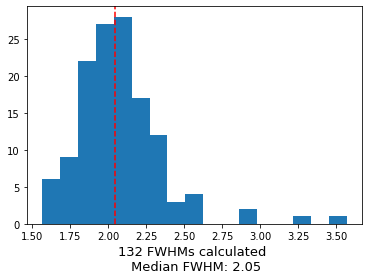

In [94]:
# Get the median FWHM
median_FWHM = GetFWHM(data = data, sources = sources, makeplot = False)